In [31]:
import phoebe
from phoebe import u, c

import matplotlib.pyplot as plt

import os
import sys
from pathlib import Path
baseModulePath = str(Path(os.getcwd()).parents[2].absolute())
if baseModulePath not in sys.path:
	sys.path.append(baseModulePath)

import importlib
import analisis.phoebe_model.utils as gen_utils
importlib.reload(gen_utils)

logger = phoebe.logger(clevel='WARNING')

In [2]:
b = phoebe.load("../optimizers/bundle-saves/poro-aviles-invq/after_optimizers")

# Renaming Datasets

Getting dataset names to play nice with plotting; math latex parser errors out with `lc_gaia_g_raw` due to 2 consecutive underscores (`_g` part probably).

In [3]:
originalDatasets = [d for d in b.datasets if d != 'mesh01']
originalDatasets

['lc_iturbide_raw',
 'lc_gaia_g_raw',
 'lc_gaia_rp_raw',
 'lc_gaia_bp_raw',
 'lc_iturbide_full_raw']

In [4]:
# using own iturbide flux sigmas for now
fullIturbideSigmas = b.get_value(qualifier='sigmas', dataset='lc_iturbide_full_raw', context='dataset')
avilesIturbideFlux = b.get_value(qualifier='fluxes', dataset='lc_iturbide_raw', context='dataset')
b.add_dataset('lc', dataset='lcIturbideAviles', overwrite=True,
			  times=b.get_value(qualifier='times', dataset='lc_iturbide_raw', context='dataset'),
			  fluxes=b.get_value(qualifier='fluxes', dataset='lc_iturbide_raw', context='dataset'),
			  sigmas=fullIturbideSigmas[:len(avilesIturbideFlux)])
b.add_dataset('lc', dataset='lcIturbideFull', overwrite=True,
			  times=b.get_value(qualifier='times', dataset='lc_iturbide_full_raw', context='dataset'),
			  fluxes=b.get_value(qualifier='fluxes', dataset='lc_iturbide_full_raw', context='dataset'),
			  sigmas=b.get_value(qualifier='sigmas', dataset='lc_iturbide_full_raw', context='dataset'))

b.add_dataset('lc', dataset='lcGaiaG', overwrite=True, passband='Gaia:G',
			  times=b.get_value(qualifier='times', dataset='lc_gaia_g_raw', context='dataset'),
			  fluxes=b.get_value(qualifier='fluxes', dataset='lc_gaia_g_raw', context='dataset'),
			  sigmas=b.get_value(qualifier='sigmas', dataset='lc_gaia_g_raw', context='dataset'))
b.add_dataset('lc', dataset='lcGaiaRP', overwrite=True, passband='Gaia:RP',
			  times=b.get_value(qualifier='times', dataset='lc_gaia_rp_raw', context='dataset'),
			  fluxes=b.get_value(qualifier='fluxes', dataset='lc_gaia_rp_raw', context='dataset'),
			  sigmas=b.get_value(qualifier='sigmas', dataset='lc_gaia_rp_raw', context='dataset'))
b.add_dataset('lc', dataset='lcGaiaBP', overwrite=True, passband='Gaia:BP',
			  times=b.get_value(qualifier='times', dataset='lc_gaia_bp_raw', context='dataset'),
			  fluxes=b.get_value(qualifier='fluxes', dataset='lc_gaia_bp_raw', context='dataset'),
			  sigmas=b.get_value(qualifier='sigmas', dataset='lc_gaia_bp_raw', context='dataset'))

<ParameterSet: 47 parameters | contexts: constraint, dataset, compute, figure>

In [5]:
gaiaDatasets = [d for d in b.datasets if 'Gaia' in d]
iturbideDatasets = ['lcIturbideAviles', 'lcIturbideFull']
allDatasets = gaiaDatasets + iturbideDatasets
plotAllDatasetsGroups = [['lcIturbideAviles'], ['lcIturbideFull'], gaiaDatasets]

In [6]:
# copying pblum to new datasets
b.set_value_all(qualifier='pblum_mode', dataset=['lcIturbideAviles', 'lcIturbideFull', 'lcGaiaG'], value='component-coupled')
b.set_value_all(qualifier='pblum_mode', dataset=['lcGaiaRP', 'lcGaiaBP'], value='dataset-coupled')
b.set_value_all(qualifier='pblum_dataset', dataset=['lcGaiaRP', 'lcGaiaBP'], value='lcGaiaG')

for newDataset, originalDataset in zip(['lcIturbideAviles', 'lcIturbideFull', 'lcGaiaG'], ['lc_iturbide_raw', 'lc_iturbide_full_raw', 'lc_gaia_g_raw']):
	dataset_pblum = b.get_quantity(qualifier='pblum', component='primary', dataset=originalDataset, context='dataset')
	b.set_value(qualifier='pblum', component='primary', dataset=newDataset, value=dataset_pblum)

100%|██████████| 1964/1964 [02:12<00:00, 14.79it/s]


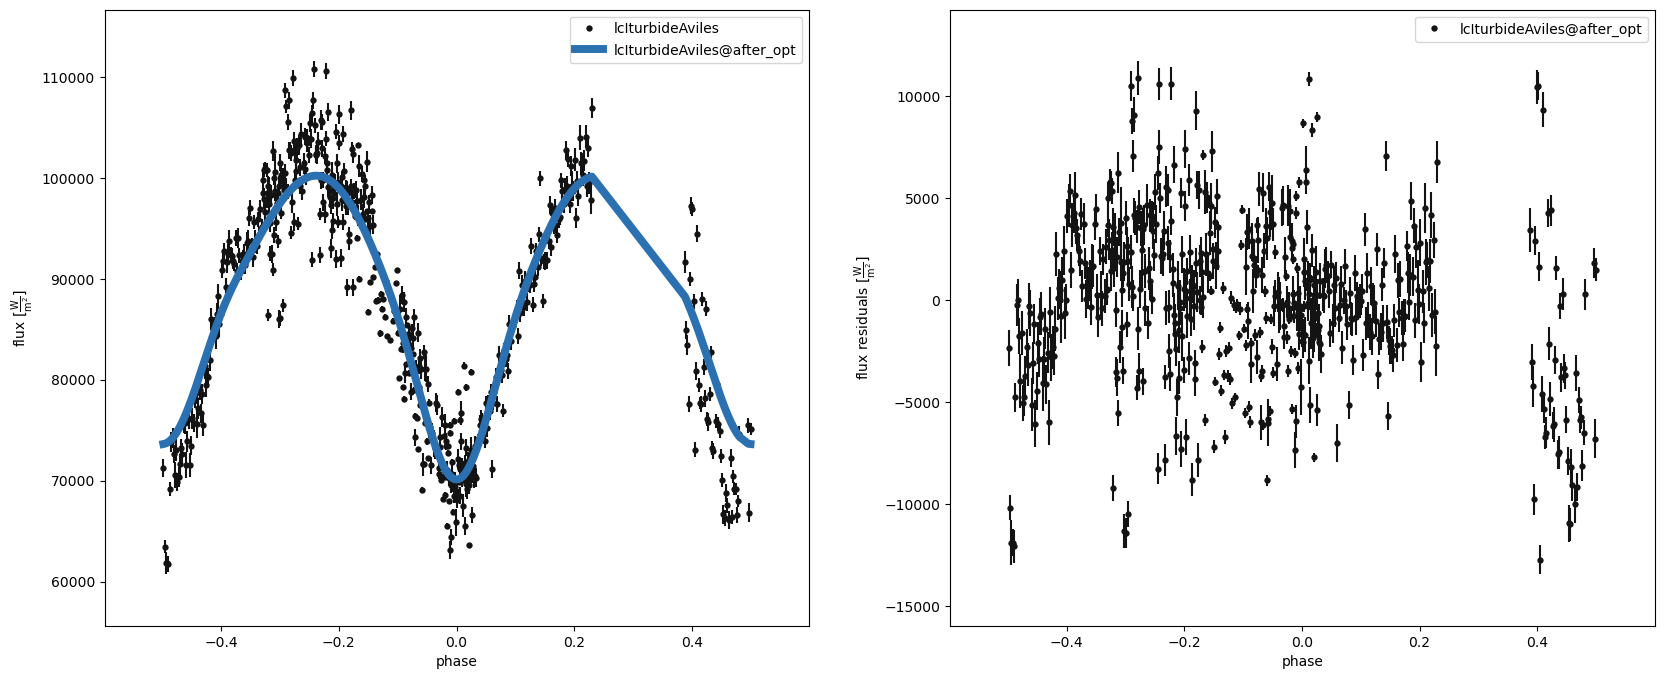

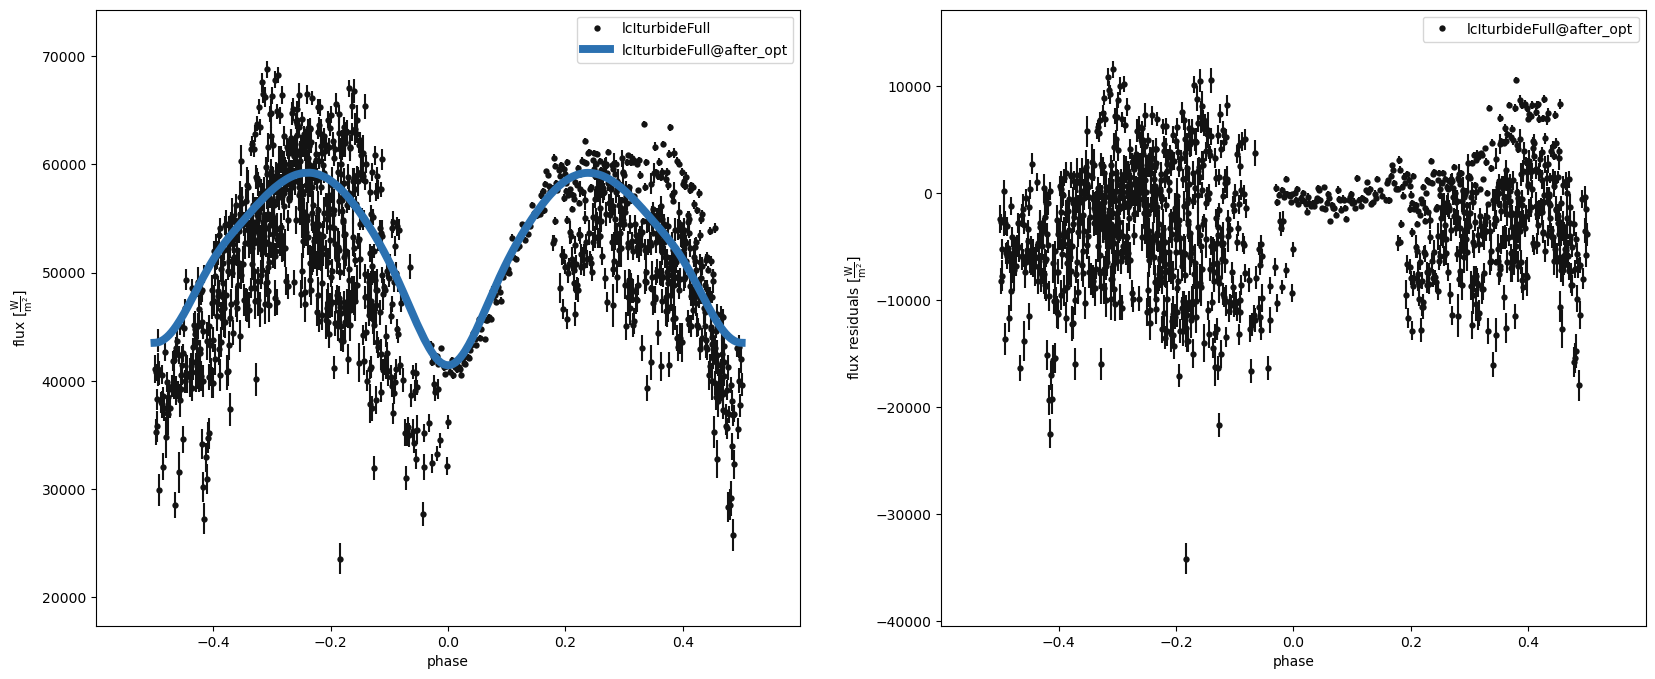

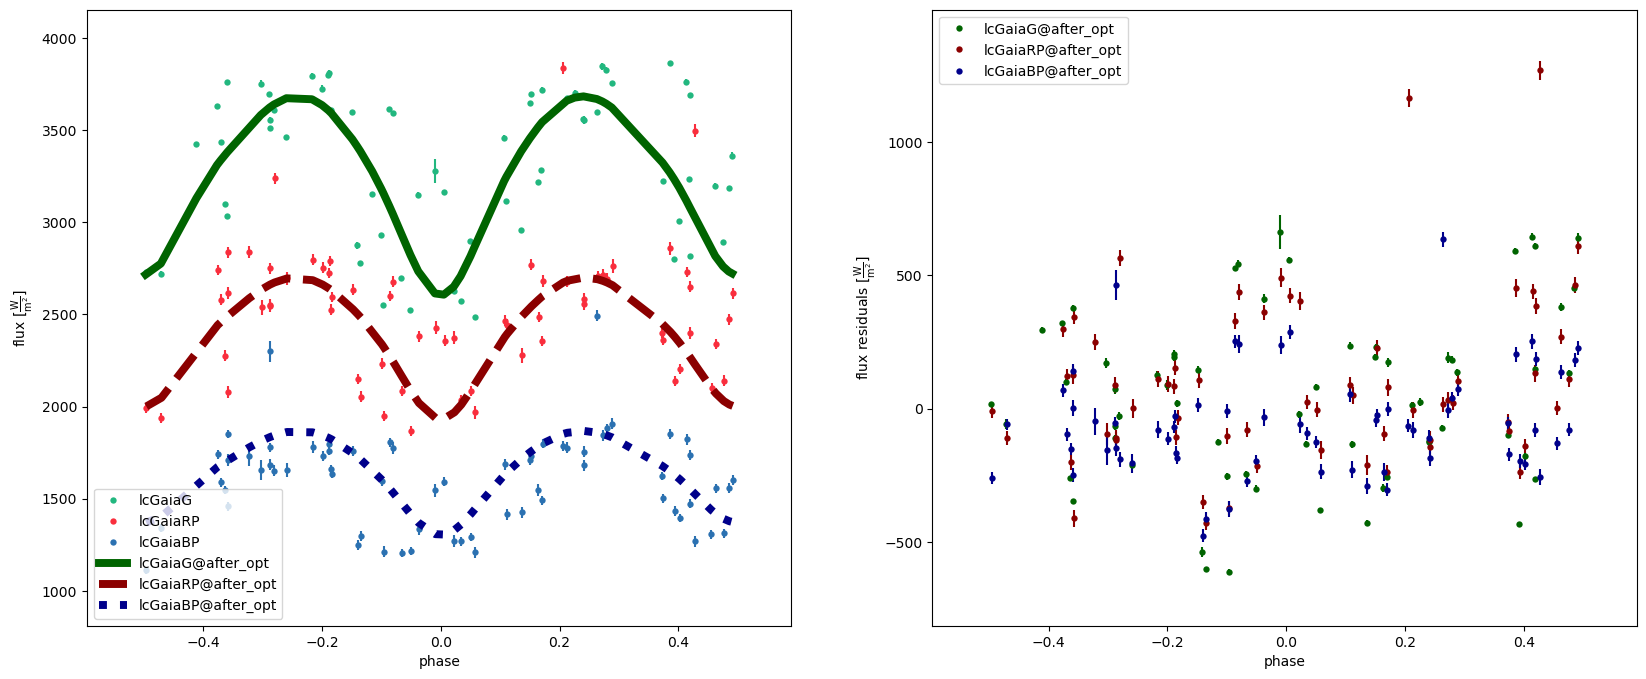

<Figure size 800x600 with 0 Axes>

GridspecLayout(children=(HTML(value='<video width="800" height="600" controls autoplay loop>\n  <source type="…

In [7]:
gen_utils.abilitateDatasets(b, allDatasets)
b.run_compute(model='after_opt', overwrite=True)
gen_utils.plotModelResidualsFigsize(b, (20, 8), plotAllDatasetsGroups, model='after_opt')
gen_utils.animateMesh(b, logger, model='after_opt')

In [8]:
for d in originalDatasets:
	b.remove_dataset(d)

# Creating Uniform Boundary Distributions

Restricting sampler parameter space; not prescribing a shape to the parameter distribution, only interested in restricting sampler space to decrease compute 
requirements.

In [9]:
print(b.get_adjustable_parameters())

ParameterSet: 47 parameters
                  distance@system: 1.0 m
                    vgamma@system: 0.0 km / s
                        Av@system: 0.0
                        Rv@system: 3.1
           teff@primary@component: 4138.4308834938365 K
        syncpar@primary@component: 1.0
      gravb_bol@primary@component: 0.32
   irrad_frac_refl_bol@primary...: 0.6
           mass@primary@component: 1.0087816199638129 solMass
      syncpar@secondary@component: 1.0
    gravb_bol@secondary@component: 0.32
   irrad_frac_refl_bol@seconda...: 0.6
          period@binary@component: 0.33354138280951534 d
            dpdt@binary@component: 0.0 s / yr
            per0@binary@component: 0.0 deg
          dperdt@binary@component: 0.0 deg / yr
             ecc@binary@component: 0.0
      t0_supconj@binary@component: 0.07183187311538936 d
            incl@binary@component: 68.77716874302344 deg
               q@binary@component: 0.2861274842133835
         long_an@binary@component: 0.0 deg
   abun@c

In [10]:
b.add_distribution({
	'teff@primary': phoebe.uniform_around(500),
	'teffratio': phoebe.uniform_around(0.1),
	'fillout_factor': phoebe.uniform_around(0.2),
	'incl@binary': phoebe.uniform_around(15),
	'q': phoebe.uniform_around(0.10),
	'mass@primary': phoebe.uniform_around(0.5)
}, distribution='bounds_around', overwrite_all=True)

b.add_distribution({
	'pblum@primary@lcIturbideAviles': phoebe.uniform_around(100_000)
}, distribution='bounds_pblum_aviles_iturbide', overwrite_all=True)

b.add_distribution({
	'pblum@primary@lcIturbideFull': phoebe.uniform_around(100_000)
}, distribution='bounds_pblum_full_iturbide', overwrite_all=True)

b.add_distribution({
	'pblum@primary@lcGaiaG': phoebe.uniform_around(5000)
}, distribution='bounds_pblum_gaia_g', overwrite_all=True)

<ParameterSet: 1 parameters>

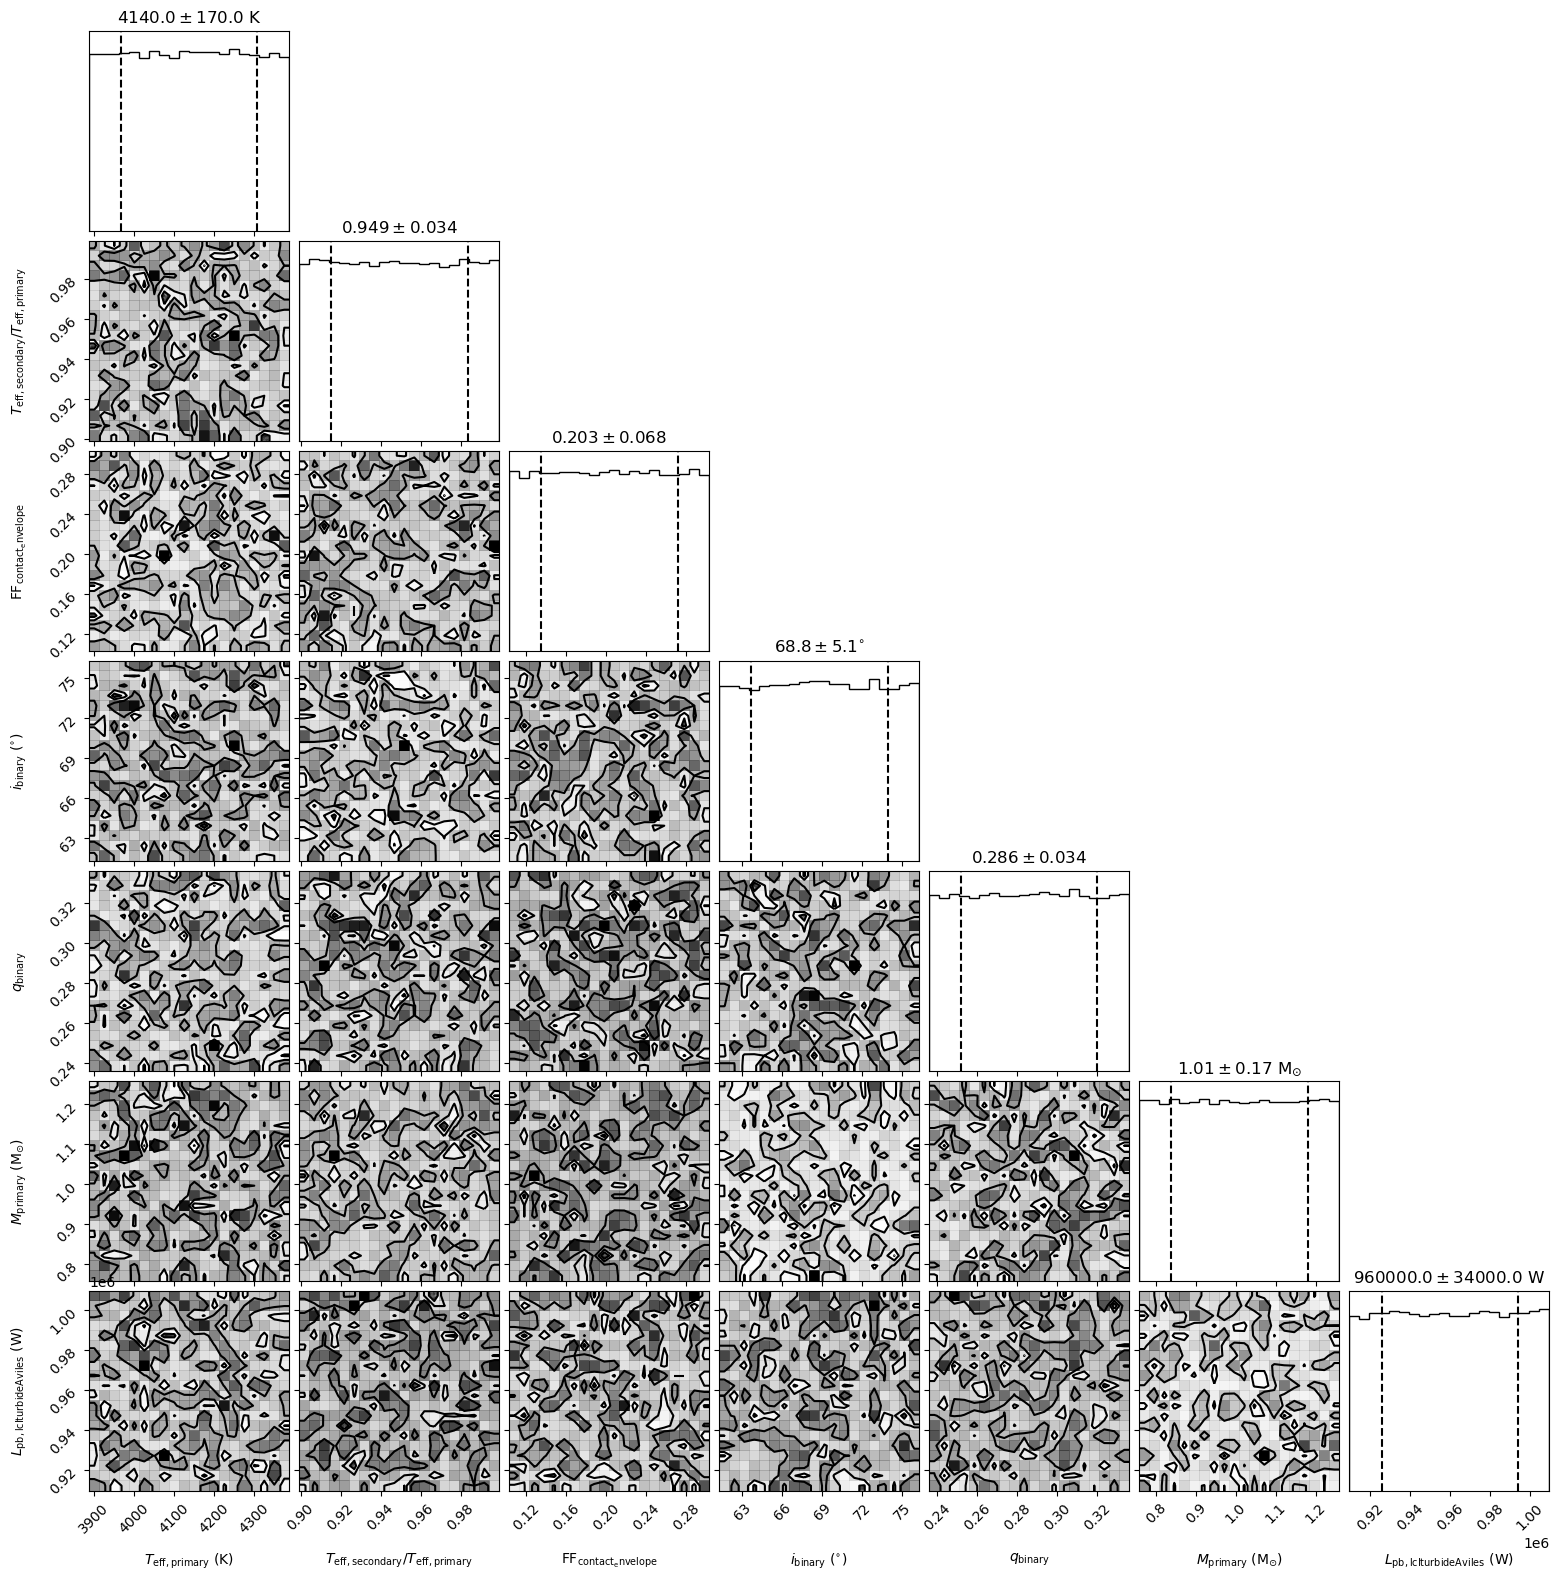

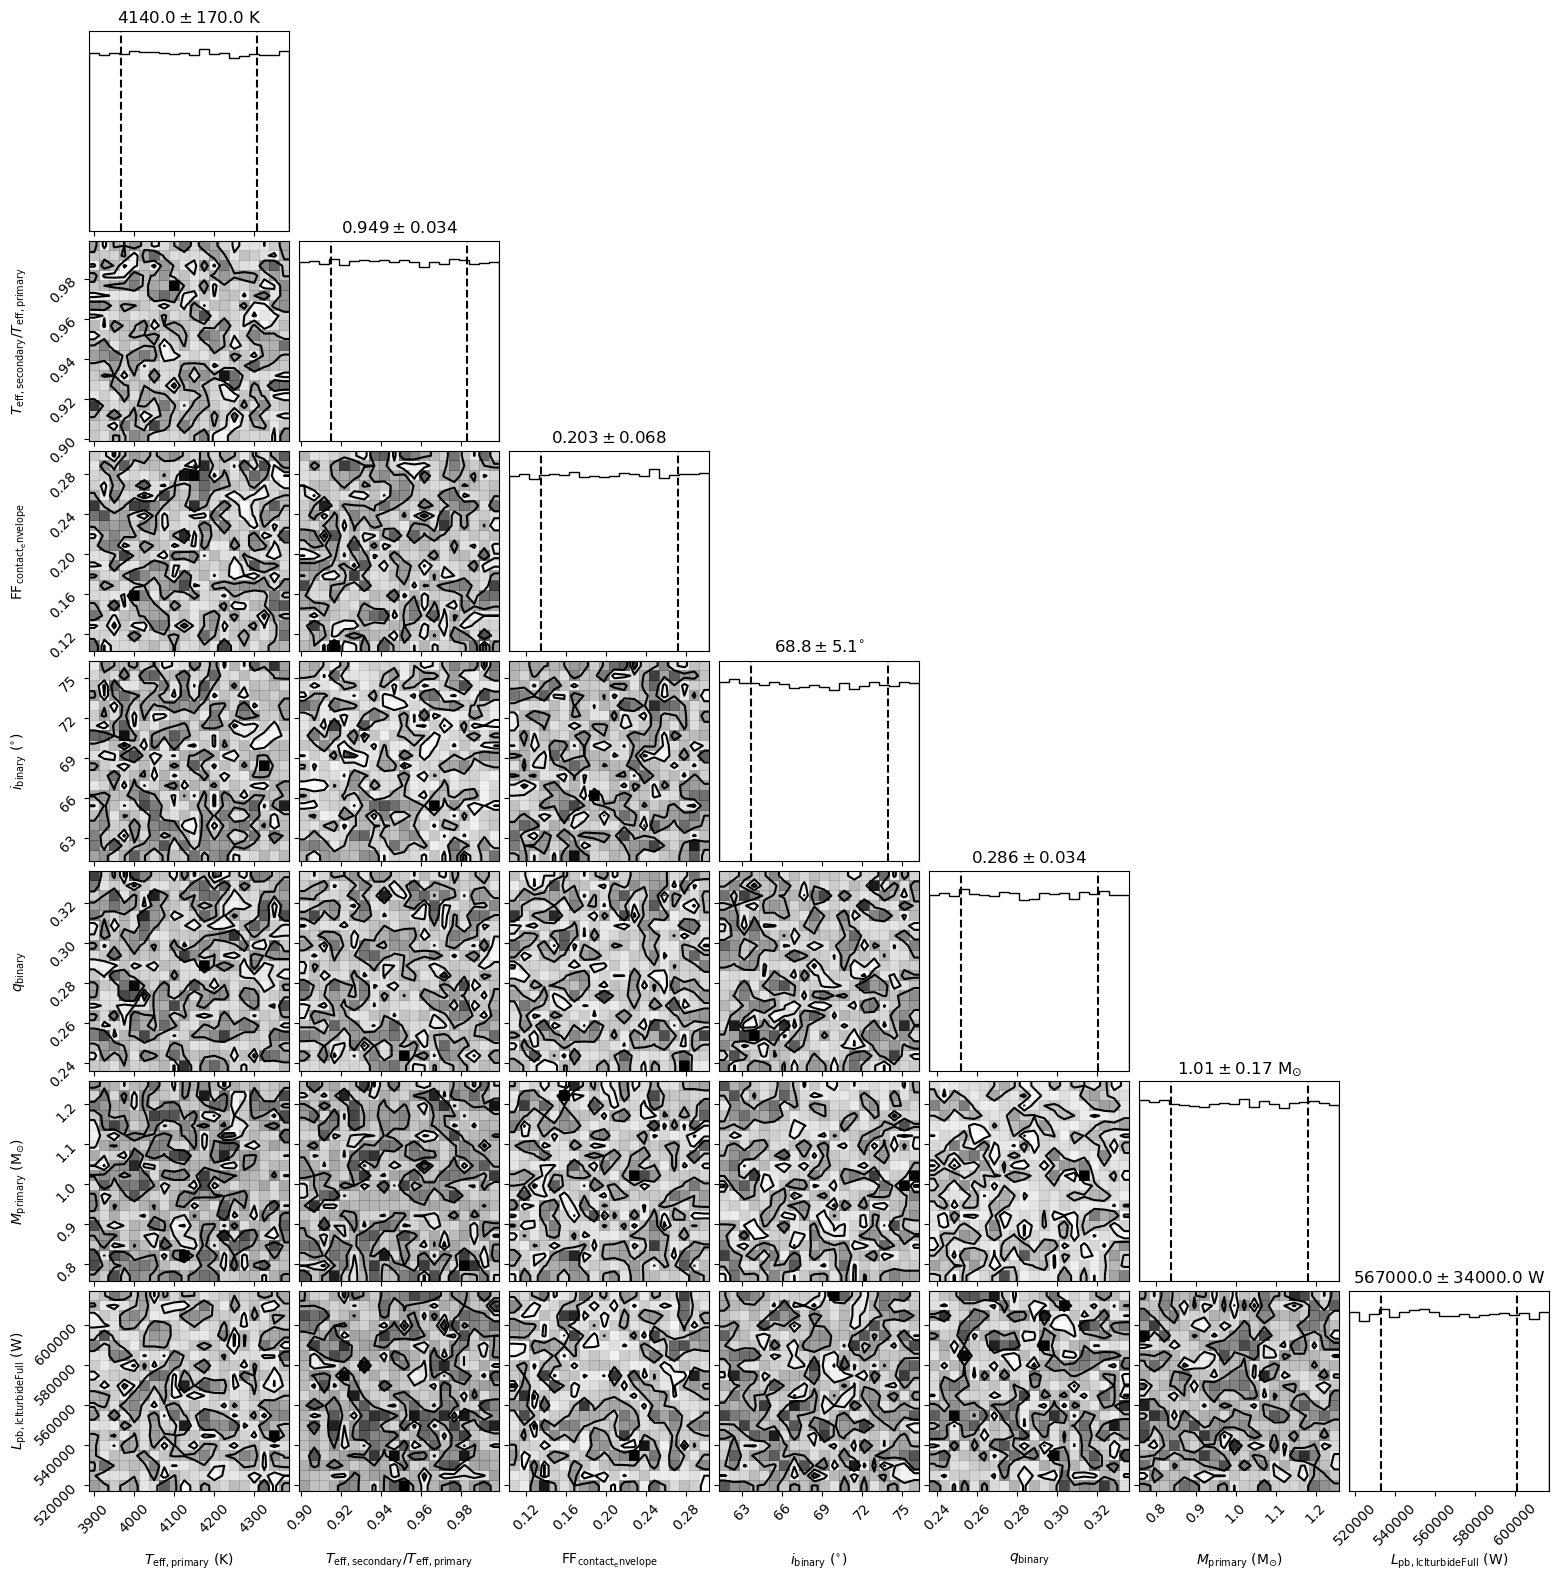

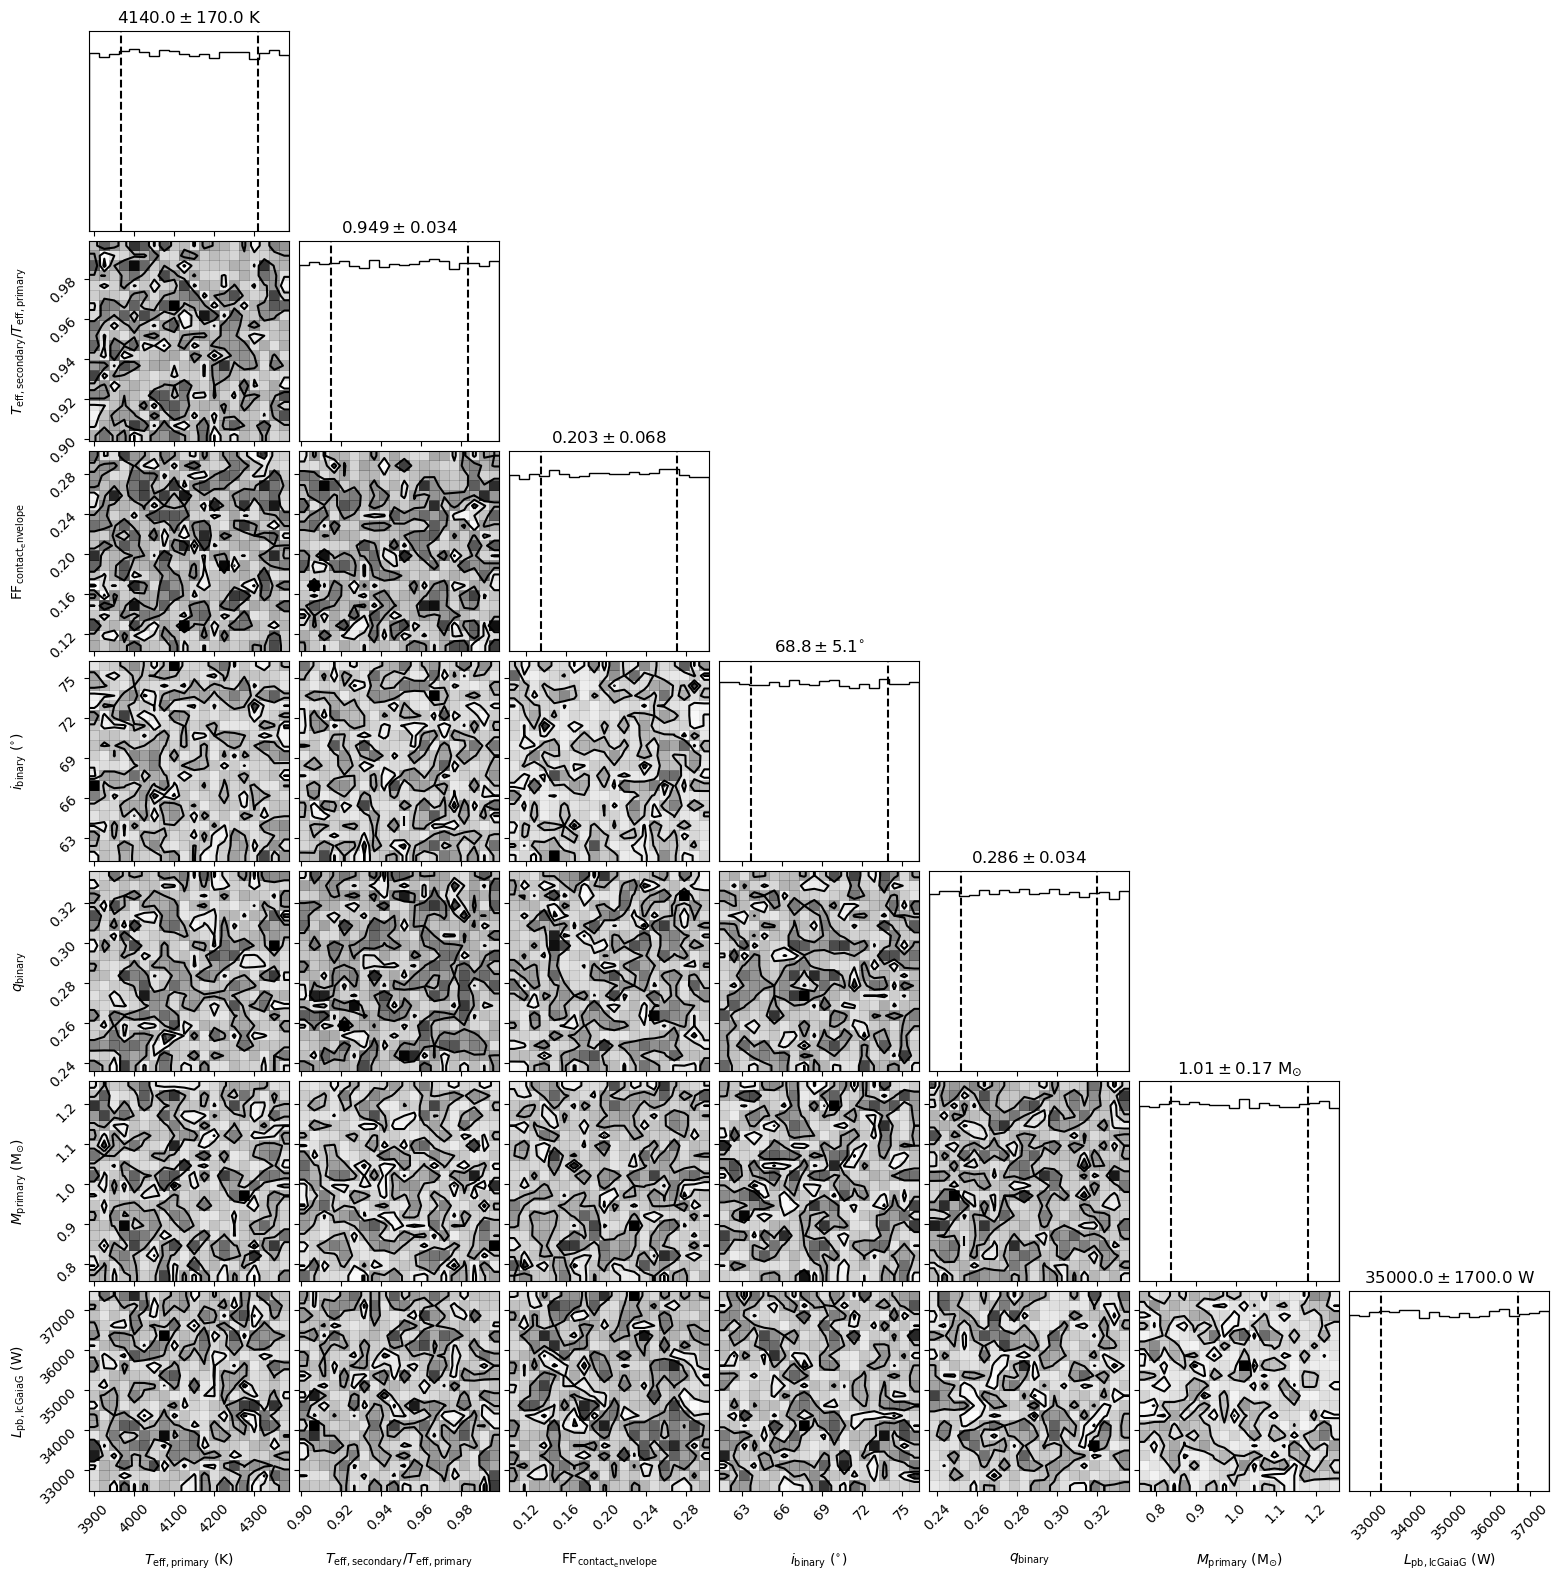

In [11]:
_ = b.plot_distribution_collection(['bounds_around', 'bounds_pblum_aviles_iturbide'], show=True)
_ = b.plot_distribution_collection(['bounds_around', 'bounds_pblum_full_iturbide'], show=True)
_ = b.plot_distribution_collection(['bounds_around', 'bounds_pblum_gaia_g'], show=True)

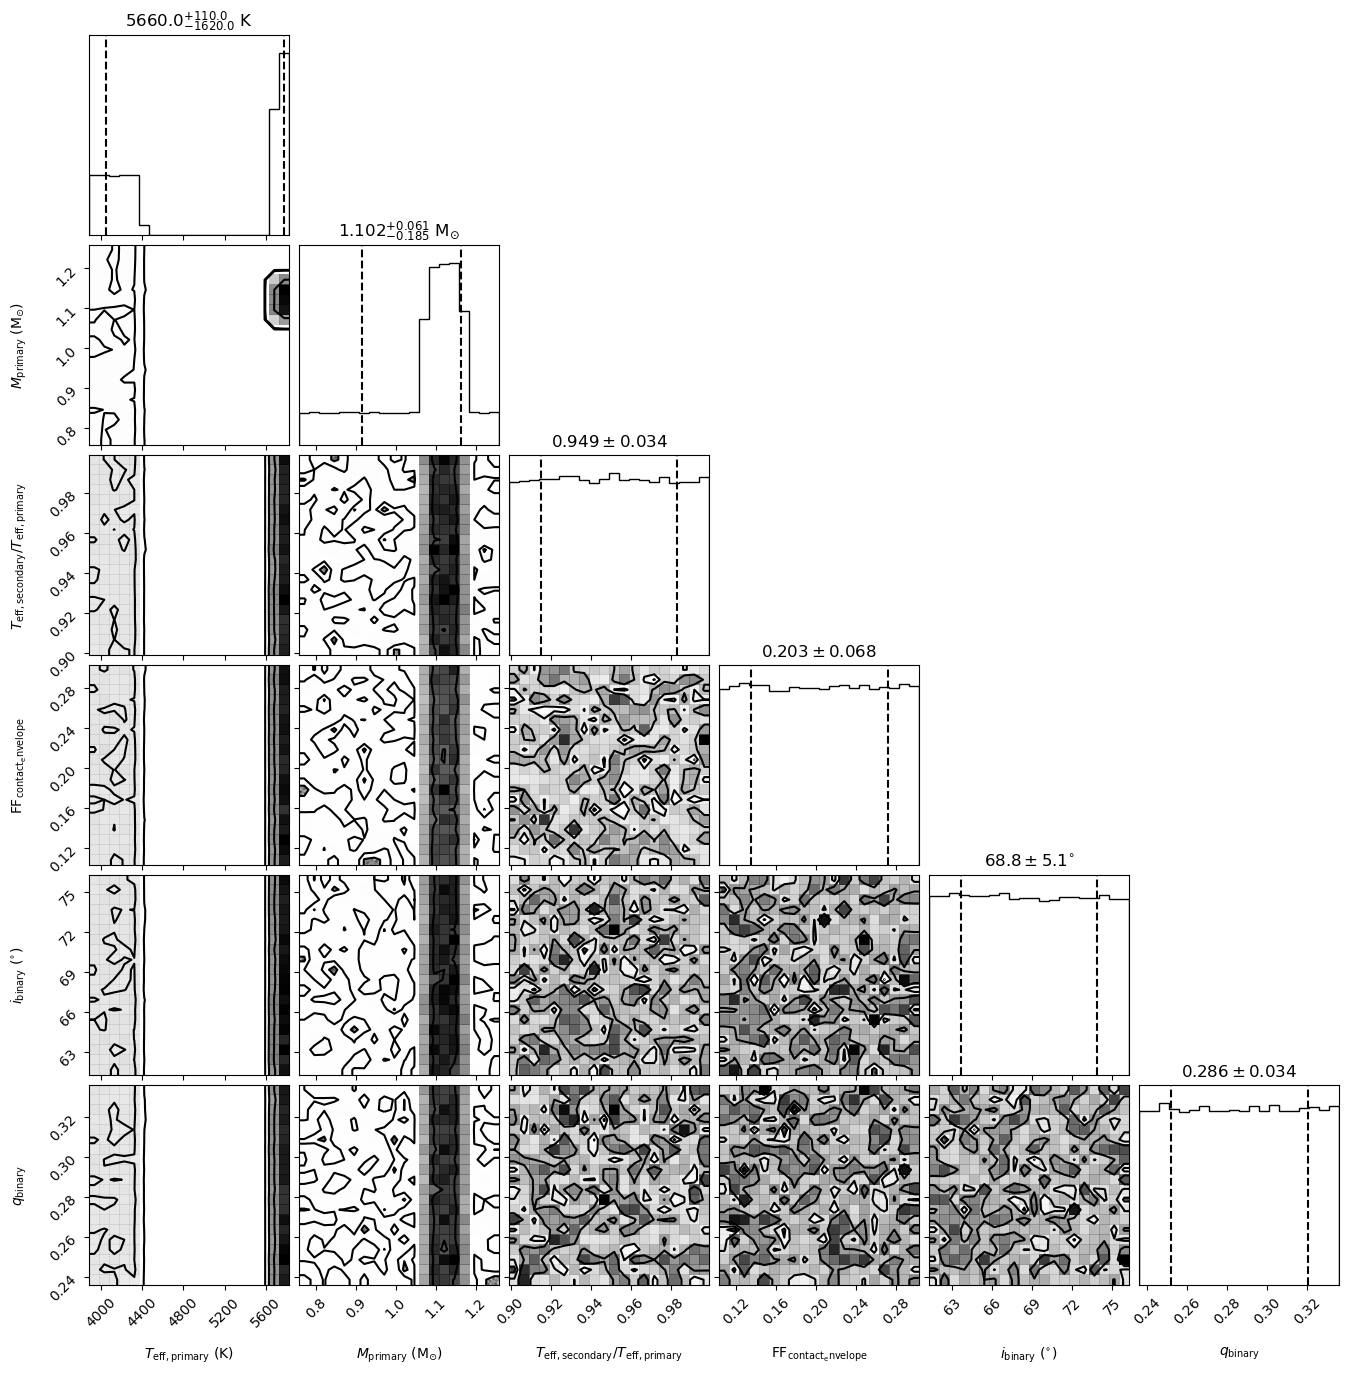

In [12]:
_ = b.plot_distribution_collection(['poro_porb_bounds', 'bounds_around'], combine='or', show=True)

# Sampled Compute Models

**SKIPPING**; whole script fails on external server when attempting to compute model with OoB parameters. Haven't found an option in documentation to ignore/skip
these errors.

In [13]:
%%script echo "skipping"
gen_utils.abilitateDatasets(b, allDatasets)
print(b['enabled'])

skipping


In [14]:
%%script echo "skipping; for compute that falls out of physical bounds, compute fails"
gen_utils.exportCompute(b, model='from_bounds_around', datasets=allDatasets, subfolder='aviles-invq', 
						sample_from='bounds_around', sample_num=50)
gen_utils.exportCompute(b, model='from_ba_pbgaia', datasets=gaiaDatasets, subfolder='aviles-invq',
						sample_from=['bounds_around', 'bounds_pblum_gaia_g'], sample_num=50)

skipping; for compute that falls out of physical bounds, compute fails


# MCMC Sampling

In [69]:
def exportSampler(b: phoebe.Bundle, sampler_solver: str, datasets: list[str], subfolder: str = None, **solver_kwargs) -> None:
	exportFolder = "external-jobs"
	if subfolder is not None:
		exportFolder = os.path.join(exportFolder, subfolder)
	os.makedirs(exportFolder, exist_ok=True)

	prevEnabledDatasets = [d for d in b.datasets if b.get_value(qualifier='enabled', dataset=d)]
	gen_utils.abilitateDatasets(b, datasets, False)
	try:
		b.add_solver('sampler.emcee', solver=sampler_solver, overwrite=True, **solver_kwargs)
		exportFilePath = os.path.join(exportFolder, f"{sampler_solver}.py")
		resultsFilePath = os.path.join("results", sampler_solver)
		fname, out_fname = b.export_solver(script_fname=exportFilePath, out_fname=resultsFilePath, solver=sampler_solver, solution=f"{sampler_solver}_solution")
		print(sampler_solver, fname, out_fname, sep=" | ")
	finally:
		gen_utils.abilitateDatasets(b, prevEnabledDatasets)

def continueSampler(b: phoebe.Bundle, prev_solver_label: str, continuation_label: str, datasets: list[str], subfolder: str = None, **solver_kwargs) -> None:
	exportFolder = "external-jobs"
	if subfolder is not None:
		exportFolder = os.path.join(exportFolder, subfolder)
	os.makedirs(exportFolder, exist_ok=True)

	prevEnabledDatasets = [d for d in b.datasets if b.get_value(qualifier='enabled', dataset=d)]
	gen_utils.abilitateDatasets(b, datasets)

	try:
		exportFilePath = os.path.join(exportFolder, f"{continuation_label}.py")
		resultsFilePath = os.path.join("results", f"{continuation_label}_solution")
		fname, out_fname = b.export_solver(script_fname=exportFilePath, out_fname=resultsFilePath, solver=prev_solver_label, solution=f"{continuation_label}_solution", 
									 continue_from=f"{prev_solver_label}_solution", **solver_kwargs)
		print(prev_solver_label, fname, out_fname, sep=" | ")
	finally:
		gen_utils.abilitateDatasets(b, prevEnabledDatasets)

def plotSamplerAcceptanceFractions(b: phoebe.Bundle, sampler_solution: str) -> None:
	nwalkers = b.get_value(qualifier='nwalkers', solution=sampler_solution)

	plt.figure(figsize=(15, 4))
	walkersIds = list(map(lambda wid: str(wid), range(0, nwalkers)))
	plt.bar(x=walkersIds, height=b.get_value(qualifier='acceptance_fractions', solution=sampler_solution))
	plt.ylim(0, 1)
	plt.xlim(-1, nwalkers + 1)

	plt.fill_between(list(range(-1, len(walkersIds) + 1)), 0.4, 0.8, color='goldenrod', alpha=0.4, label="Desired range")
	plt.title(f"{sampler_solution} Acceptance Fractions")
	plt.legend()

## Iturbide Sampling

In [18]:
exportSampler(b, 'mcmc_iturbide_full', subfolder='aviles-invq', datasets=['lcIturbideFull'],
			  init_from=['bounds_around', 'bounds_pblum_full_iturbide'], nwalkers=32, niters=100, progress_every_niters=10)
print(b['mcmc_iturbide_full'])

mcmc_iturbide_full | external-jobs/aviles-invq/mcmc_iturbide_full.py | results/mcmc_iturbide_full
ParameterSet: 15 parameters
   comments@mcmc_iturbide_full...: 
   use_server@mcmc_iturbide_fu...: compute
   compute@mcmc_iturbide_full@...: phoebe01
   continue_from@mcmc_iturbide...: None
   init_from@mcmc_iturbide_ful...: ['bounds_around', 'bounds_pblum_full_iturbide']
   init_from_combine@mcmc_itur...: first
   init_from_requires@mcmc_itu...: ['limits', 'priors']
   priors@mcmc_iturbide_full@s...: []
   nwalkers@mcmc_iturbide_full...: 32
   niters@mcmc_iturbide_full@s...: 100
   burnin_factor@mcmc_iturbide...: 2.0
   thin_factor@mcmc_iturbide_f...: 0.0
   nlags_factor@mcmc_iturbide_...: 3.0
   progress_every_niters@mcmc_...: 10
   expose_failed@mcmc_iturbide...: True


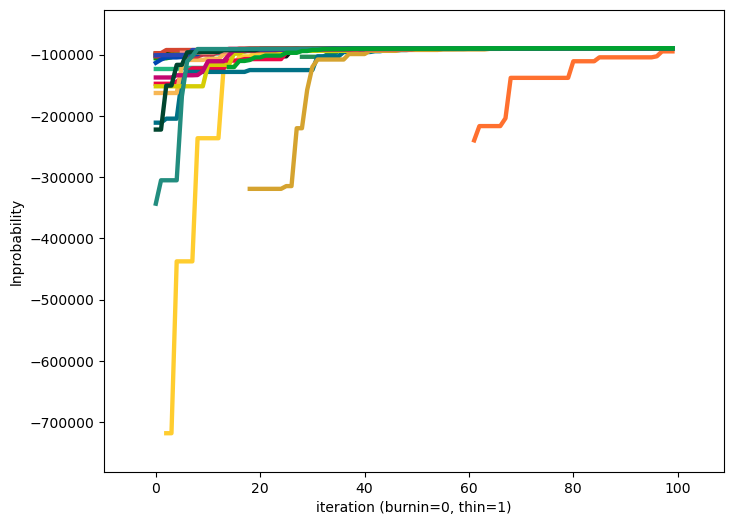

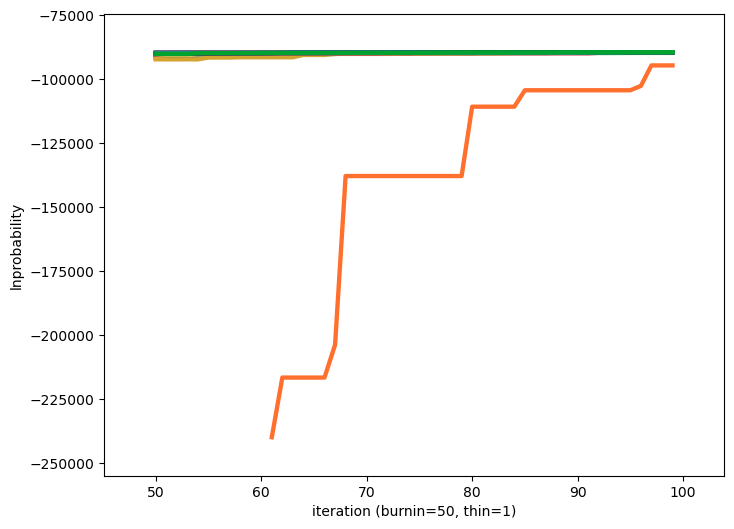

(<autofig.figure.Figure | 1 axes | 25 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [21]:
b.import_solution(fname="./external-jobs/aviles-invq/results/mcmc_iturbide_full", overwrite=True)
# b.solutions
b.plot(solution='mcmc_iturbide_full_solution', style='lnprobability', burnin=0, thin=1, show=True)
b.plot(solution='mcmc_iturbide_full_solution', style='lnprobability', burnin=50, thin=1, show=True)

(None, <Figure size 1600x1600 with 49 Axes>)

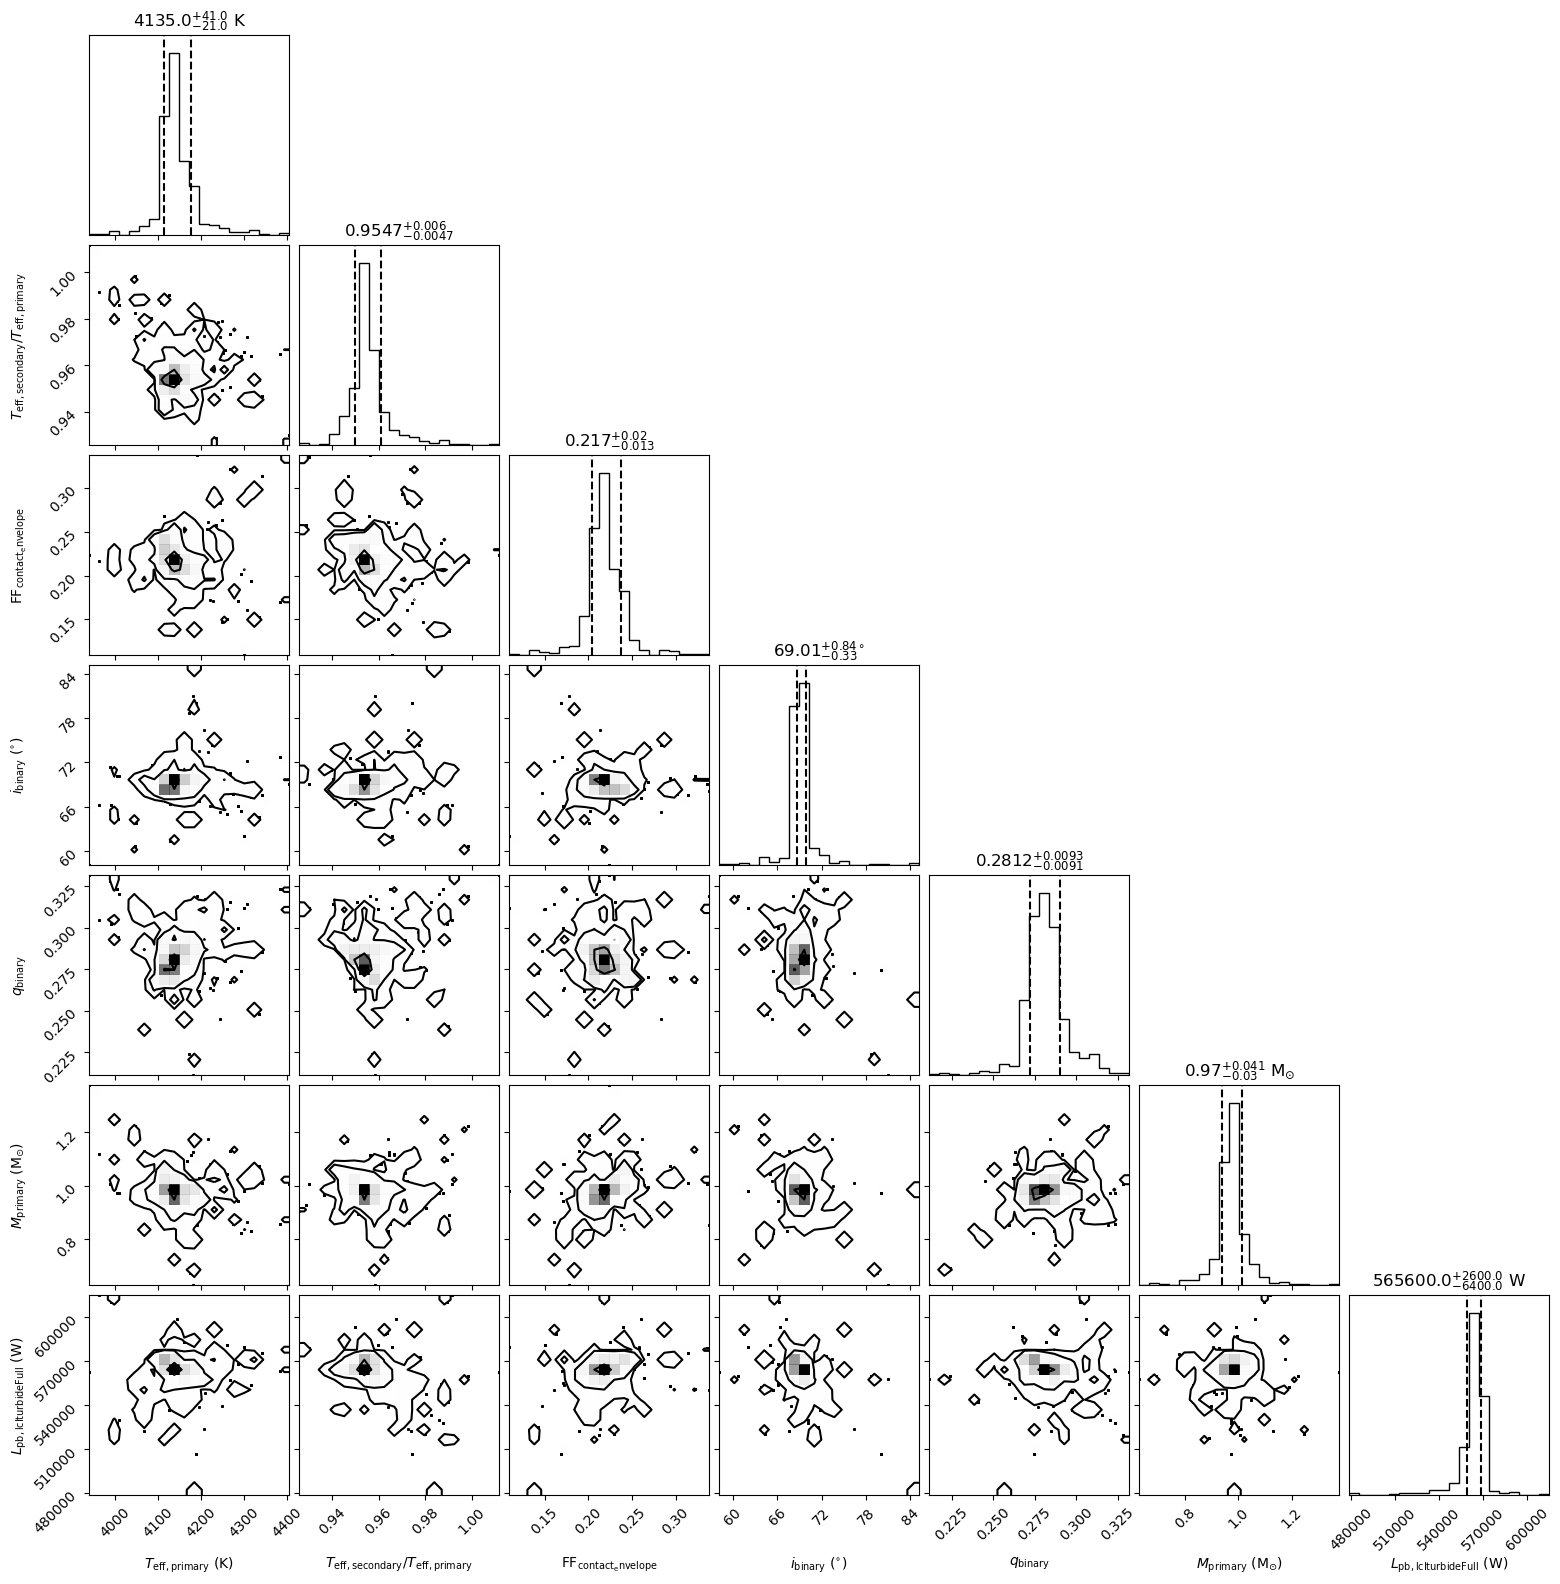

In [24]:
b.plot(solution='mcmc_iturbide_full_solution', style='corner', burnin=0, thin=1, show=True)

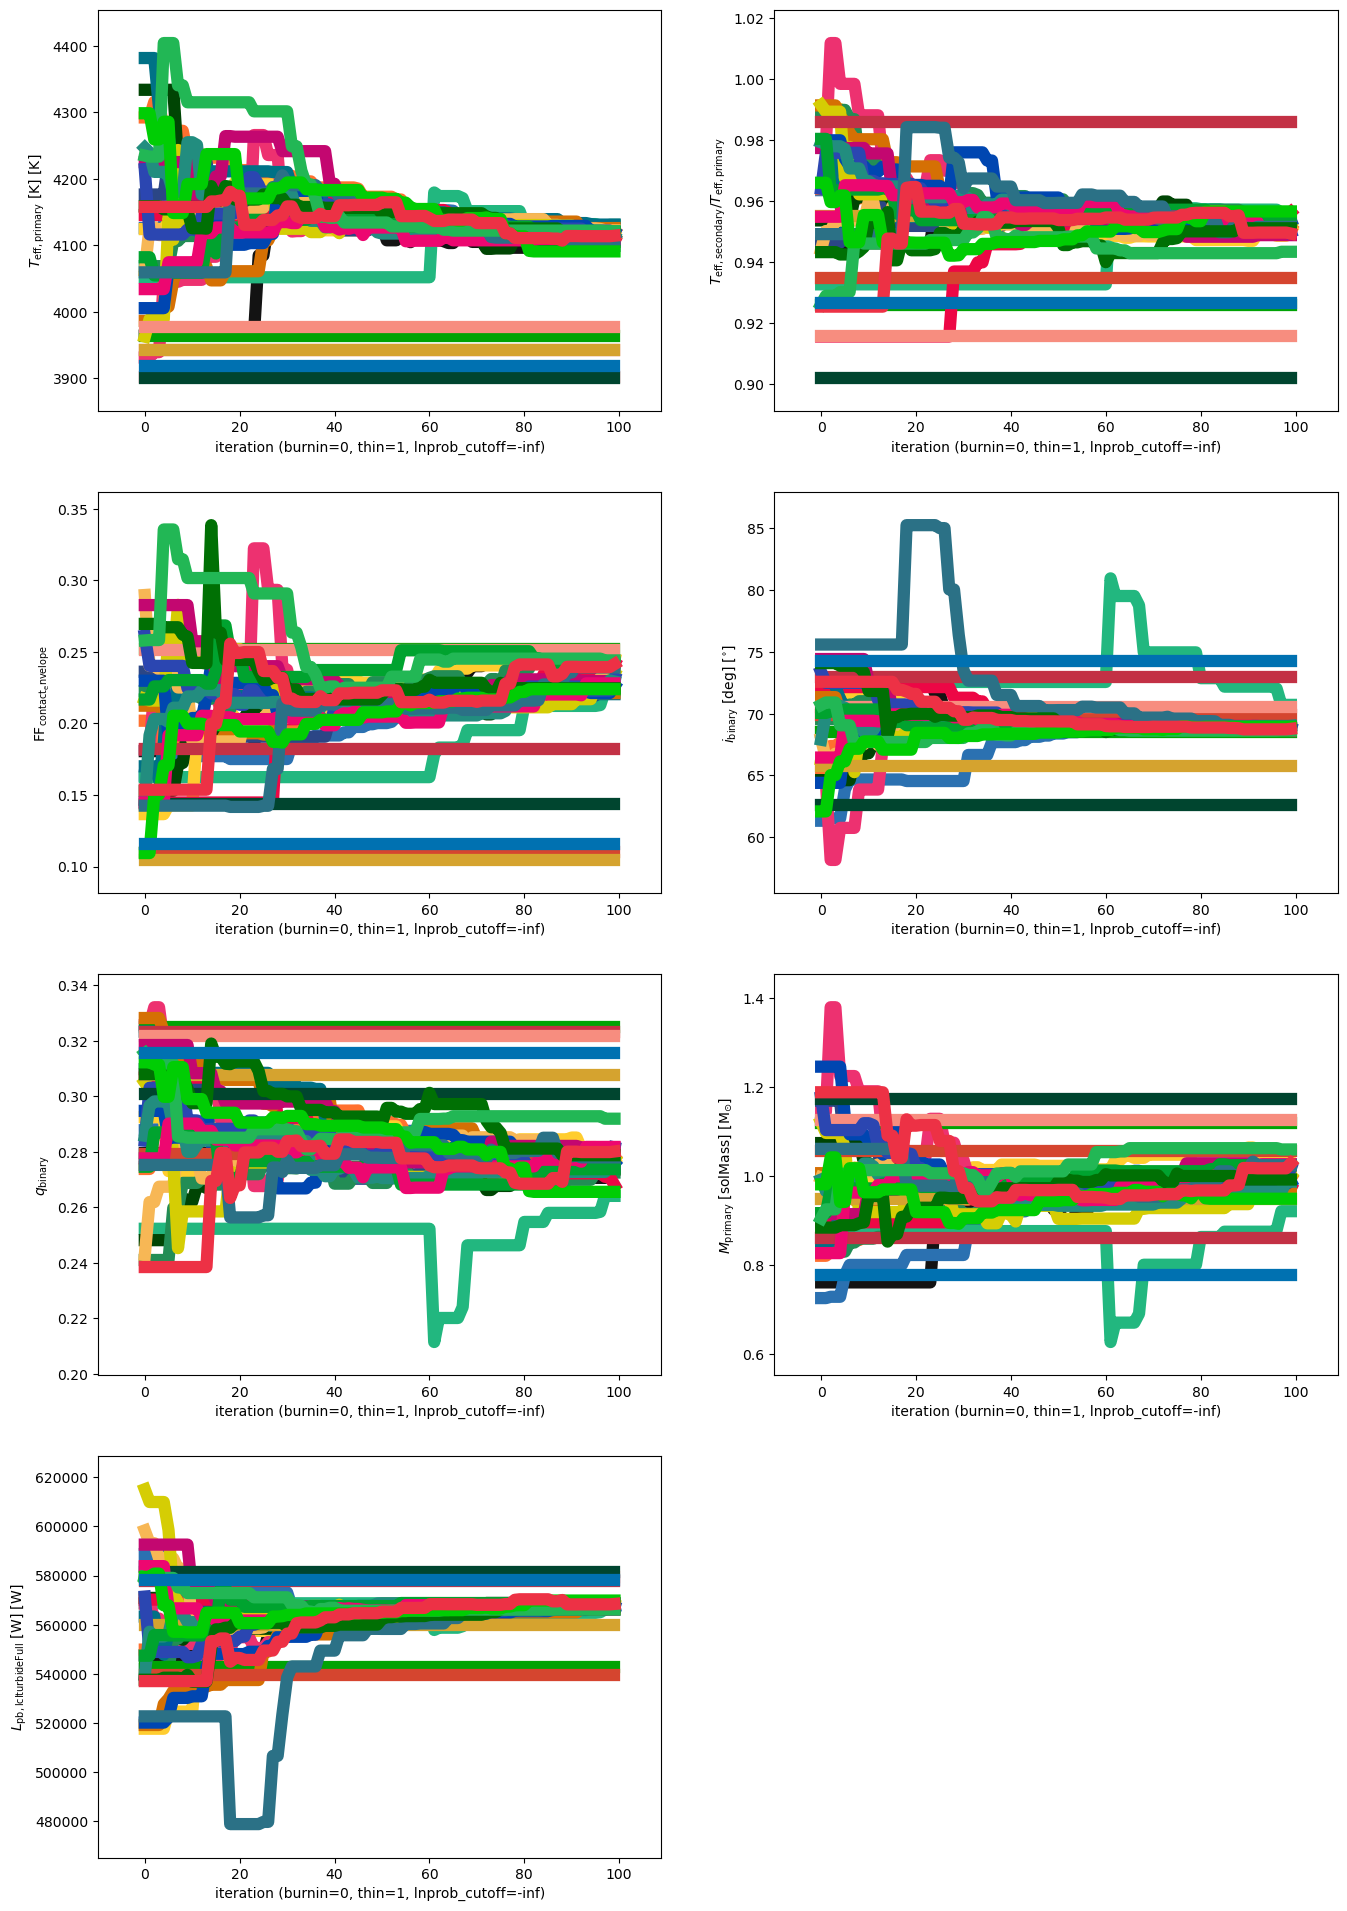

(<autofig.figure.Figure | 7 axes | 224 call(s)>,
 <Figure size 1600x2400 with 7 Axes>)

In [26]:
b.plot(solution='mcmc_iturbide_full_solution', style='trace', burnin=0, thin=1, show=True)

In [41]:
b['mcmc_iturbide_full_solution'].qualifiers

['wrap_central_values',
 'fitted_twigs',
 'fitted_units',
 'adopt_parameters',
 'adopt_distributions',
 'distributions_convert',
 'adopt_values',
 'niters',
 'nwalkers',
 'samples',
 'failed_samples',
 'lnprobabilities',
 'acceptance_fractions',
 'autocorr_times',
 'burnin',
 'thin',
 'nlags',
 'lnprob_cutoff',
 'progress',
 'comments',
 'imported_job']

Parameter: autocorr_times@mcmc_iturbide_full_solution@solution
                       Qualifier: autocorr_times
                     Description: measured autocorrelation time with shape (len(fitted_twigs)) before applying burnin/thin.  To access with a custom burnin/thin, see phoebe.helpers.get_emcee_object_from_solution
                           Value: [nan nan nan nan nan nan nan]
                  Constrained by: 
                      Constrains: None
                      Related to: None



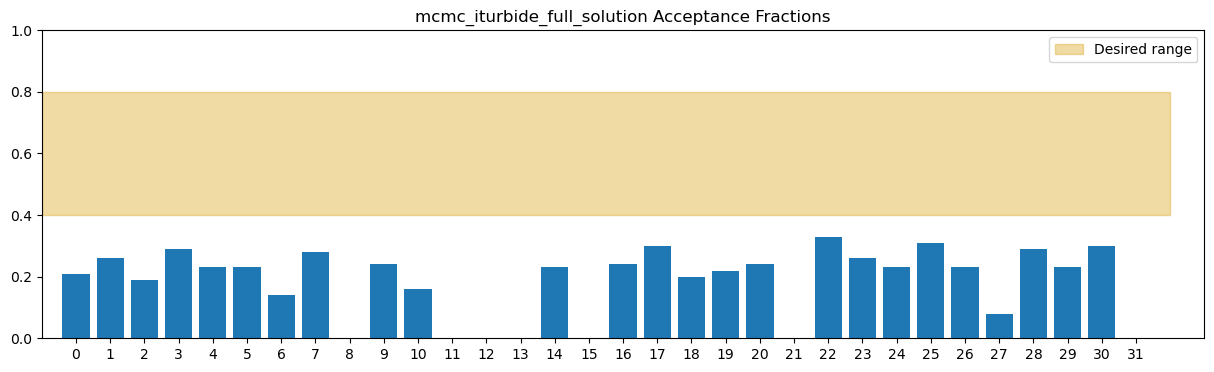

In [70]:
print(b['mcmc_iturbide_full_solution@autocorr_times'])

plotSamplerAcceptanceFractions(b, 'mcmc_iturbide_full_solution')

In [66]:
# continue sampling from previous run to run a total of 800 iterations

continueSampler(b, "mcmc_iturbide_full", "mcmc_iturbide_full_round2", datasets=['lcIturbideFull'], subfolder="aviles-invq", niters=700)

mcmc_iturbide_full | external-jobs/aviles-invq/mcmc_iturbide_full_round2.py | results/mcmc_iturbide_full_round2_solution


## Gaia Sampling

In [25]:
b.distributions

['poro_porb_bounds',
 'bounds_around',
 'bounds_pblum_aviles_iturbide',
 'bounds_pblum_full_iturbide',
 'bounds_pblum_gaia_g']

In [71]:
exportSampler(b, 'mcmc_gaia', subfolder='aviles-invq', datasets=gaiaDatasets,
			  init_from=['bounds_around', 'bounds_pblum_gaia_g'], nwalkers=32, niters=1000, progress_every_niters=10)
print(b['mcmc_gaia'])

mcmc_gaia | external-jobs/aviles-invq/mcmc_gaia.py | results/mcmc_gaia
ParameterSet: 15 parameters
        comments@mcmc_gaia@solver: 
      use_server@mcmc_gaia@solver: compute
         compute@mcmc_gaia@solver: phoebe01
   continue_from@mcmc_gaia@solver: None
       init_from@mcmc_gaia@solver: ['bounds_around', 'bounds_pblum_gaia_g']
   init_from_combine@mcmc_gaia...: first
   init_from_requires@mcmc_gai...: ['limits', 'priors']
          priors@mcmc_gaia@solver: []
        nwalkers@mcmc_gaia@solver: 32
          niters@mcmc_gaia@solver: 1000
   burnin_factor@mcmc_gaia@solver: 2.0
     thin_factor@mcmc_gaia@solver: 0.0
    nlags_factor@mcmc_gaia@solver: 3.0
   progress_every_niters@mcmc_...: 10
   expose_failed@mcmc_gaia@solver: True


In [74]:
b.import_solution(fname="./external-jobs/aviles-invq/results/mcmc_gaia", overwrite=True)

<ParameterSet: 23 parameters | qualifiers: fitted_units, distributions_convert, comments, imported_job, lnprobabilities, fitted_uniqueids, samples, distributions_bins, adopt_distributions, adopt_parameters, thin, autocorr_times, lnprob_cutoff, failed_samples, burnin, wrap_central_values, nwalkers, nlags, fitted_twigs, adopt_values, niters, acceptance_fractions, progress>

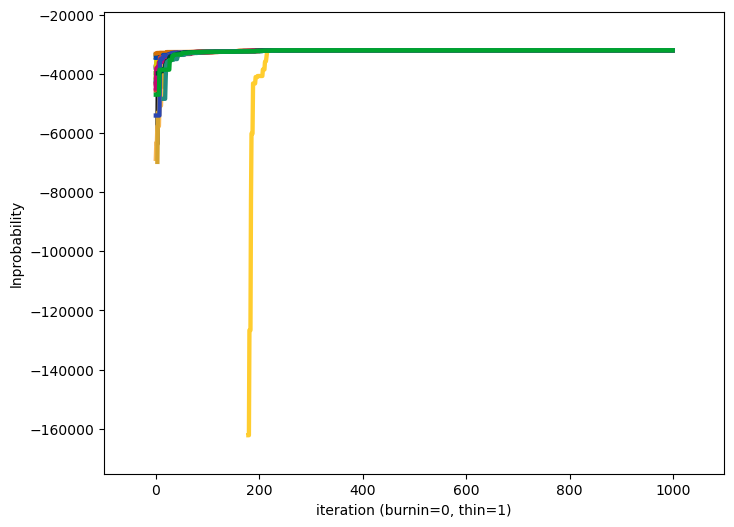

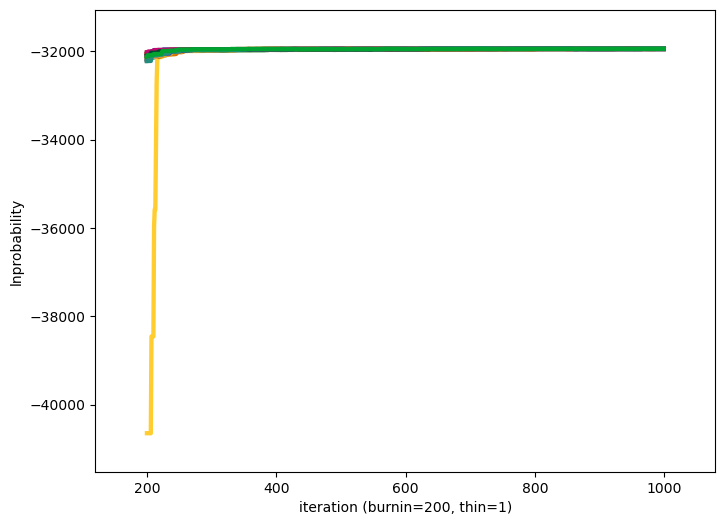

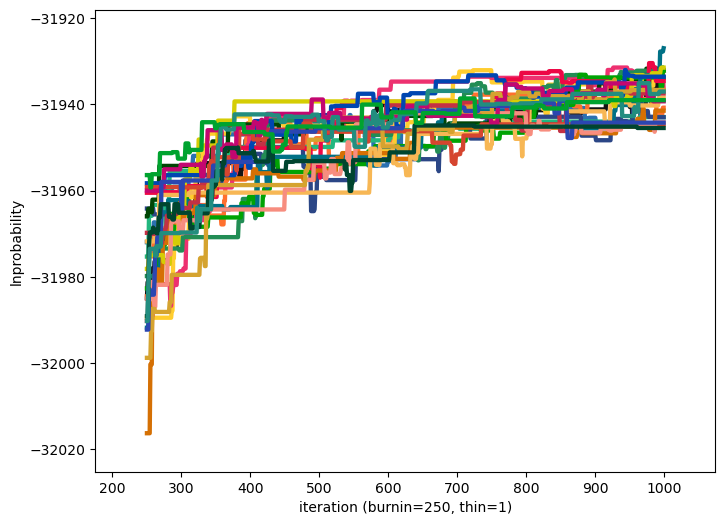

(<autofig.figure.Figure | 1 axes | 25 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [78]:
# b.plot(solution='mcmc_gaia_solution', style='lnprobability', burnin=0, thin=1, show=True)
# b.plot(solution='mcmc_gaia_solution', style='lnprobability', burnin=200, thin=1, show=True)
b.plot(solution='mcmc_gaia_solution', style='lnprobability', burnin=250, thin=1, show=True)

In [83]:
print(b['pblum'])

ParameterSet: 6 parameters
   pblum@primary@lcIturbideAvi...: 959718.3862413258 W
   pblum@primary@lcIturbideFul...: 567161.6312684531 W
    pblum@primary@lcGaiaG@dataset: 34979.800770998816 W
   pblum@lcIturbideAviles@boun...: <distl.uniform_around width=100000.0 value=959718.3862413258 unit=W frac=False>
   pblum@lcIturbideFull@bounds...: <distl.uniform_around width=100000.0 value=567161.6312684531 unit=W frac=False>
   pblum@lcGaiaG@bounds_pblum_...: <distl.uniform_around width=5000.0 value=34979.800770998816 unit=W frac=False>


ParameterSet: 16 parameters
            incl@binary@component: 68.77716874302344 deg
   incl@bounds_around@distribu...: <distl.uniform_around width=15.0 value=68.77716874302344 unit=deg frac=False>
       teffratio@binary@component: 0.9493072392967905
   teffratio@bounds_around@dis...: <distl.uniform_around width=0.1 value=0.9493072392967905 unit= frac=False>
           teff@primary@component: 4138.4308834938365 K
   teff@poro_porb_bounds@distr...: <distl.uniform low=5663.112795884727 high=5826.126240382796 unit=K label=teff@primary label_latex=$T_{ \mathrm{ eff }, \mathrm{ primary } }$>
   teff@bounds_around@distribu...: <distl.uniform_around width=500.0 value=4138.4308834938365 unit=K frac=False>
           mass@primary@component: 1.0087816199638129 solMass
   mass@poro_porb_bounds@distr...: <distl.uniform low=1.0682593994618288 high=1.1762906068747014 unit=solMass label=mass@primary label_latex=$M_\mathrm{ primary }$>
   mass@bounds_around@distribu...: <distl.uniform_around width=0.

(None, <Figure size 1600x1600 with 49 Axes>)

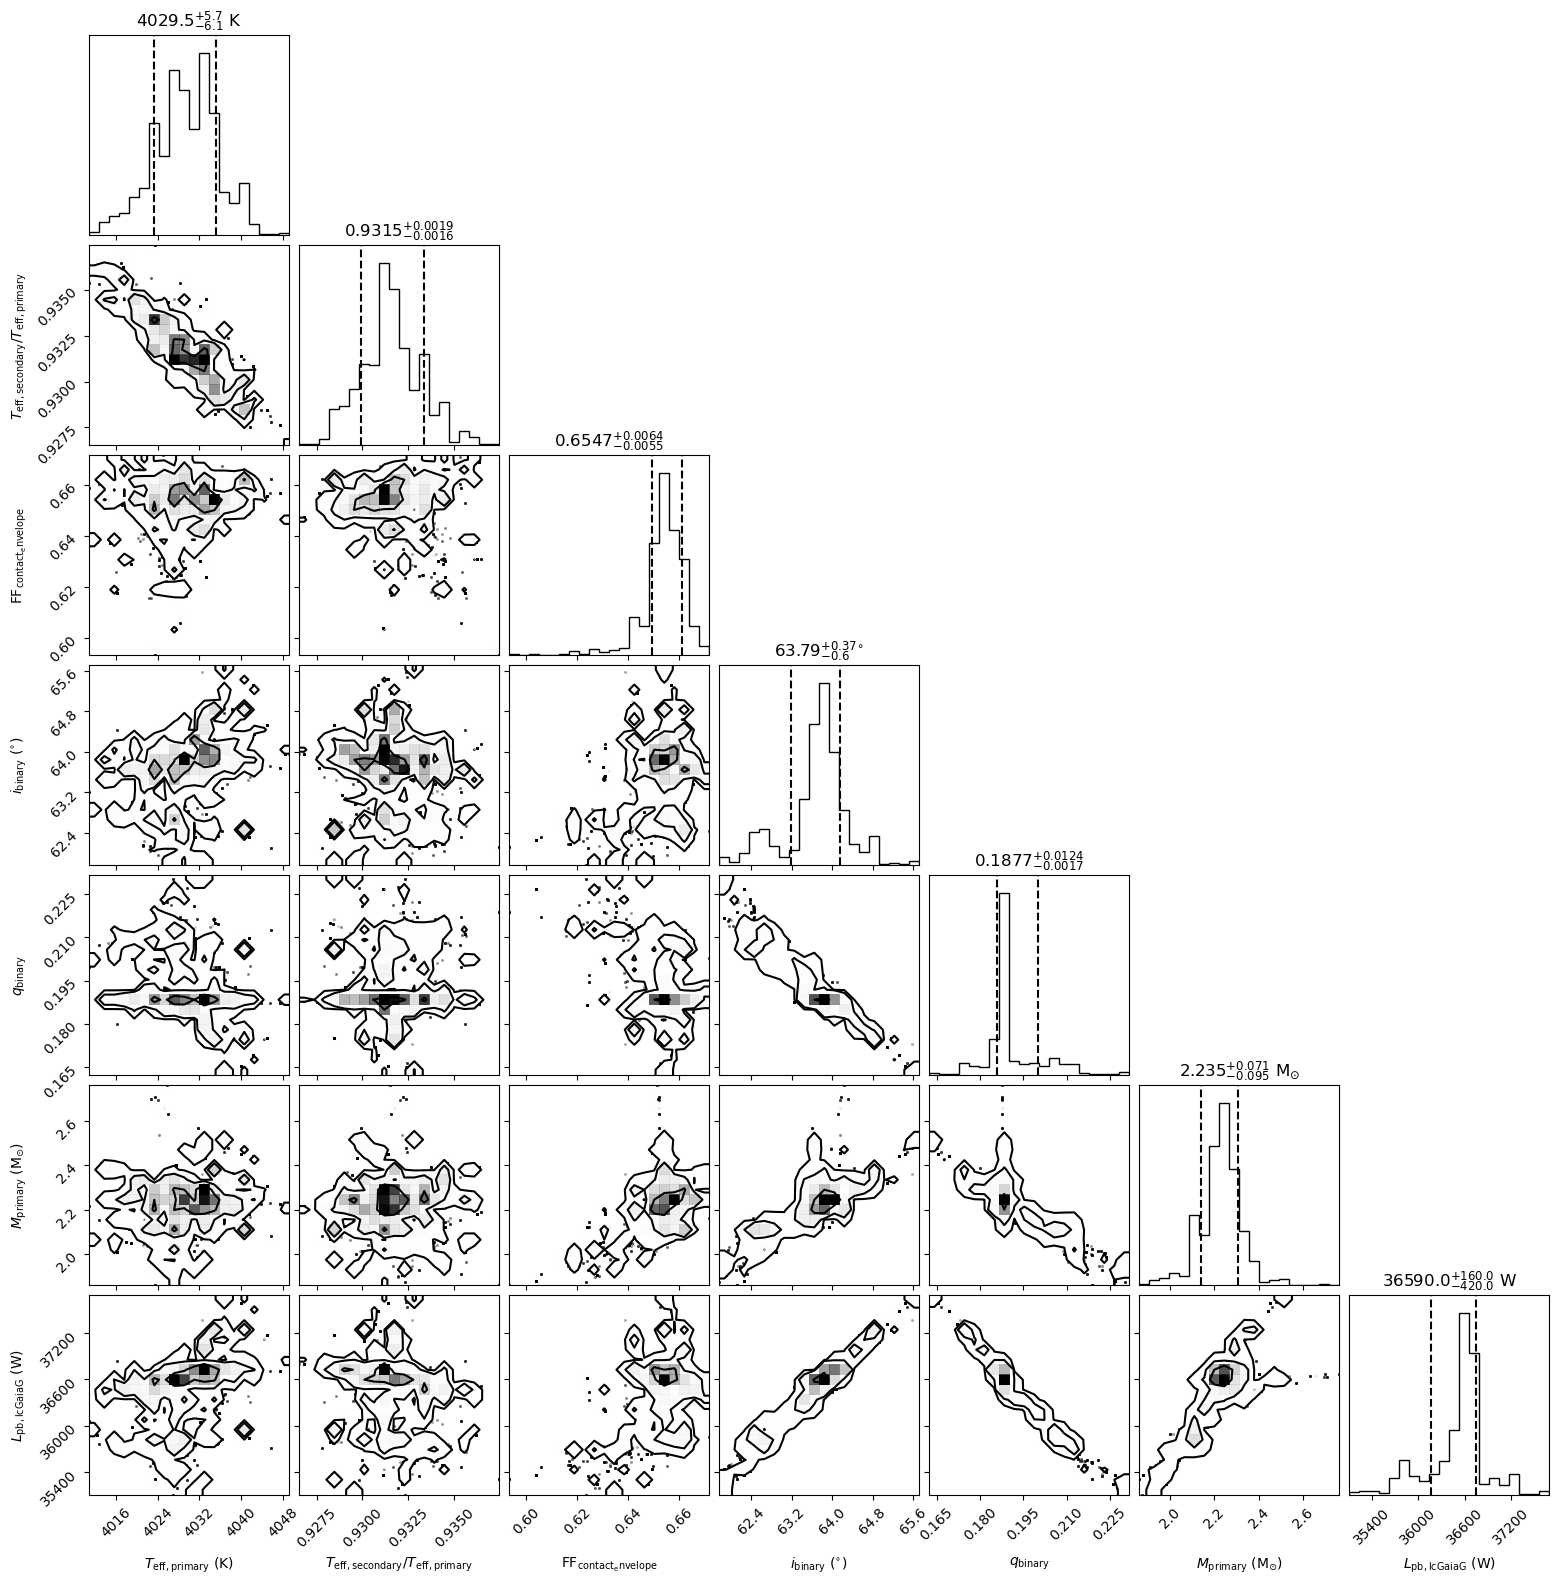

In [85]:
print(b.filter(['incl@binary', 'teffratio', 'teff@primary', 'mass@primary', 'fillout_factor', 'q', 'pblum@primary@lcGaiaG']))
b.plot(solution='mcmc_gaia_solution', style='corner', burnin=250, thin=1, show=True)